In [1]:
from dysh.spectra.spectrum import Spectrum
import numpy as np
from scipy.stats import norm
import astropy.units as u
import matplotlib.pyplot as plt
from dysh.fits.sdfitsload import SDFITSLoad
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.spectra.scan import PSScan, GBTPSScan
import pandas
from copy import deepcopy
pandas.set_option('display.max_rows', 100)
from astropy.modeling.fitting import LevMarLSQFitter,LinearLSQFitter
from specutils import Spectrum1D, SpectrumList,SpectralRegion
from astropy.nddata import StdDevUncertainty
from specutils.fitting import fit_continuum
import matplotlib.pyplot as plt
from dysh.spectra import dcmeantsys
from dysh.plot.specplot import SpectrumPlot
from astropy.io import fits
from astropy.table import Table
import pandas as pd
#%matplotlib notebook

-------------

# 1. GBTFITSLoad and position-switch calibration testing
change to use your specific `datadir`

In [2]:
datadir = '/data/gbt'
#f = datadir + '/examples/misc/ngc5291.fits'
f = datadir + '/examples/onoff-L/data/TGBT21A_501_11.raw.vegas.fits'
#f = datadir + 'examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.A.fits'
p = GBTFITSLoad(f)

In [3]:
#Table.from_pandas(
p.summary(verbose=False)

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,152.0,NGC2415,3784.0,OnOff,1.0,1.617185,5,2,3020,1,286.218008,41.62843
1,153.0,NGC2415,3784.0,OnOff,2.0,1.617185,5,2,3020,1,286.886521,41.118134


In [4]:
p.summary(verbose=True)

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,IFNUM,FEED,AZIMUTH,ELEVATIO,FDNUM,PLNUM
0,152,NGC2415,3784.0,OnOff,1,1.420406,0,1,285.951496,42.100624,0,1
1,152,NGC2415,3784.0,OnOff,1,1.420406,0,1,285.951496,42.100624,0,1
2,152,NGC2415,3784.0,OnOff,1,1.420406,0,1,285.951496,42.100624,0,0
3,152,NGC2415,3784.0,OnOff,1,1.420406,0,1,285.951496,42.100624,0,0
4,152,NGC2415,3784.0,OnOff,1,1.612231,1,1,285.951496,42.100624,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6035,153,NGC2415,3784.0,OnOff,2,1.667359,3,1,287.149353,40.652970,0,0
6036,153,NGC2415,3784.0,OnOff,2,1.720530,4,1,287.149353,40.652970,0,1
6037,153,NGC2415,3784.0,OnOff,2,1.720530,4,1,287.149353,40.652970,0,1
6038,153,NGC2415,3784.0,OnOff,2,1.720530,4,1,287.149353,40.652970,0,0


In [5]:
scanlist = [152]

In [6]:
p.write_scans("/tmp/scans.fits",overwrite=True,checksum=True,output_verify='fix',scans=scanlist)

In [7]:
p._hdu[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2022-02-14T17:25:01' / date and time this HDU was created            
ORIGIN  = 'NRAO Green Bank'    / origin of observation                          
TELESCOP= 'NRAO_GBT'           / the telescope used                             
INSTRUME= 'VEGAS   '           / backend                                        
SDFITVER= 'sdfits ver1.22'     / this file was created by sdfits                
FITSVER = '1.9     '           / FITS definition version                        

In [8]:
p.write("/tmp/foobar.fits",overwrite=True,rows=[11,15,37,99],bintable=0)
p.write("/tmp/onerows.fits",overwrite=True,rows=15,bintable=0)

In [9]:
x1 = fits.open("/tmp/scans.fits")
x1.info()

Filename: /tmp/scans.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   ()      
  1  SINGLE DISH    1 BinTableHDU    210   3020R x 74C   [32A, 1D, 22A, 1D, 1D, 1D, 32768E, 16A, 6A, 8A, 1D, 1D, 1D, 4A, 1D, 4A, 1D, 1I, 32A, 32A, 1J, 32A, 16A, 1E, 8A, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 8A, 1D, 1D, 12A, 1I, 1I, 1D, 1D, 1I, 1A, 1I, 1I, 16A, 16A, 1J, 1J, 22A, 1D, 1D, 1I, 1A, 1D, 1E, 1D, 1D, 1D, 1D, 1D, 1A, 1A, 8A, 1E, 1E, 16A, 1I, 1I, 1I]   


In [10]:
x1 = GBTFITSLoad("/tmp/scans.fits")
#x1._ptable[0]
x1._hdu.info()

Filename: /tmp/scans.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   ()      
  1  SINGLE DISH    1 BinTableHDU    210   3020R x 74C   ['32A', '1D', '22A', '1D', '1D', '1D', '32768E', '16A', '6A', '8A', '1D', '1D', '1D', '4A', '1D', '4A', '1D', '1I', '32A', '32A', '1J', '32A', '16A', '1E', '8A', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '8A', '1D', '1D', '12A', '1I', '1I', '1D', '1D', '1I', '1A', '1I', '1I', '16A', '16A', '1J', '1J', '22A', '1D', '1D', '1I', '1A', '1D', '1E', '1D', '1D', '1D', '1D', '1D', '1A', '1A', '8A', '1E', '1E', '16A', '1I', '1I', '1I']   


In [11]:
x1._hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =               131698 / length of dimension 1                          
NAXIS2  =                 3020 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   74 / number of table fields                         
COMMENT Start of SDFITS CORE keywords/columns.                                  
TELESCOP= 'NRAO_GBT'           / the telescope used                             
COMMENT End of SDFITS CORE keywords/columns.                                    
COMMENT Start of SDFITS DATA column and descriptive axes.                       
CTYPE4  = 'STOKES  '        

In [12]:
x1 = GBTFITSLoad("/tmp/foobar.fits")
#x1.nrows(0),x1._hdu[1].header
x1.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,152.0,NGC2415,3784.0,OnOff,1.0,1.693455,3,2,4,1,285.955462,42.092103


In [13]:
x1 = GBTFITSLoad("/tmp/onerows.fits")
x1.nrows(0),x1._hdu[1].header
x1.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,152.0,NGC2415,3784.0,OnOff,1.0,1.667359,1,1,1,1,285.951496,42.100624


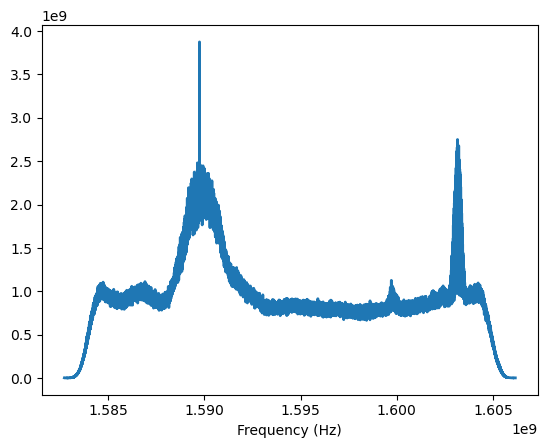

In [14]:
spec4 = p.getspec(4)
sp = SpectrumPlot(spec4)
sp.plot()

### check out some important columns.  Note the clever selection mechanism

In [30]:
columns = ["SCAN","PROC","PROCSEQN","IFNUM","PLNUM","SIG","CAL","TSYS","TCAL", "OBSMODE","FDNUM", "RESTFREQ"]
df = p._ptable[0]
df[df.columns & columns][0:20]
#df[(df['SIG'] == 'F') & (df['CAL']=='T')][(df.columns & columns)]

/tmp/ipykernel_899513/716454384.py:3: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  df[df.columns & columns][0:20]


,TSYS,SCAN,OBSMODE,TCAL,RESTFREQ,PROCSEQN,SIG,CAL,IFNUM,PLNUM,FDNUM,PROC
0,1.0,152,OnOff:PSWITCHON:TPWCAL,1.428060,1.420406e+09,1,T,F,0,1,0,OnOff
1,1.0,152,OnOff:PSWITCHON:TPWCAL,1.428060,1.420406e+09,1,T,T,0,1,0,OnOff
2,1.0,152,OnOff:PSWITCHON:TPWCAL,1.455164,1.420406e+09,1,T,F,0,0,0,OnOff
3,1.0,152,OnOff:PSWITCHON:TPWCAL,1.455164,1.420406e+09,1,T,T,0,0,0,OnOff
4,1.0,152,OnOff:PSWITCHON:TPWCAL,1.602189,1.612231e+09,1,T,F,1,1,0,OnOff
5,1.0,152,OnOff:PSWITCHON:TPWCAL,1.602189,1.612231e+09,1,T,T,1,1,0,OnOff
6,1.0,152,OnOff:PSWITCHON:TPWCAL,1.575624,1.612231e+09,1,T,F,1,0,0,OnOff
7,1.0,152,OnOff:PSWITCHON:TPWCAL,1.575624,1.612231e+09,1,T,T,1,0,0,OnOff
8,1.0,152,OnOff:PSWITCHON:TPWCAL,1.441578,1.665402e+09,1,T,F,2,1,0,OnOff
9,1.0,152,OnOff:PSWITCHON:TPWCAL,1.441578,1.665402e+09,1,T,T,2,1,0,OnOff


## Get a position switch scan and calibrate it.
The default ifnum=0, plnum=0

In [18]:
# eventually this will have calibrate=True as the default, so you don't need to call calibrate().
psscan = p.getps(152)

PSSCAN nrows = 302


In [19]:
psscan.calibrate()

### the raw calibrated numpy array

In [20]:
psscan._calibrated[0]

array([-0.36949378,  0.6447438 , -1.0699384 , ...,  1.0231373 ,
        0.17274837,  0.18792354], dtype=float32)

### A single integration of the calibrated Spectrum

In [21]:
spec1 = psscan.calibrated(0)
spec1.unit == u.K

True

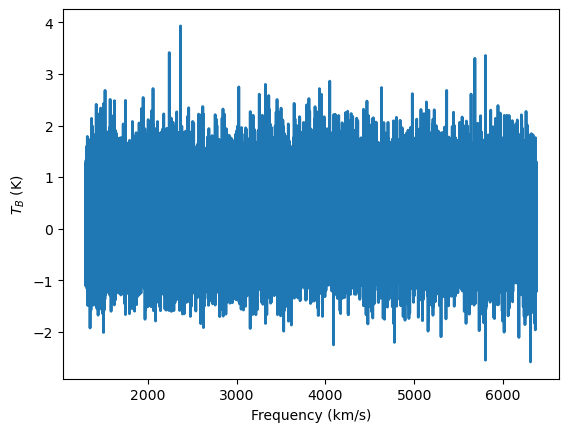

In [22]:
sp = SpectrumPlot(spec1)
sp.plot(xaxis_unit="km/s")

In [ ]:
if False:
    fig,ax = plt.subplots()
    ax.set_ylim([-4,4])
    ax.plot(spec1.spectral_axis,spec1.flux)
    ax.set_xlabel("Frequency (GHz)")
    ax.set_ylabel(r"$T_a$ (K)")

In [ ]:
## ignore this
if False:
    flx = np.mean(psscan._calibrated[np.arange(0,len(psscan._calibrated),4)])
    fig,ax = plt.subplots()
    ax.set_ylim([-4,4])
    ax.plot(psscan.calibrated(0).spectral_axis,flx)
    all(psscan.calibrated(0).spectral_axis==psscan.calibrated(3).spectral_axis),all(psscan.calibrated(4).spectral_axis==psscan.calibrated(7).spectral_axis)

### The average spectrum.  
Note this will be encapsulated in a average() method.
Compare this with GBTIDL `getps, 152`

T_sys = 17.17232315879513


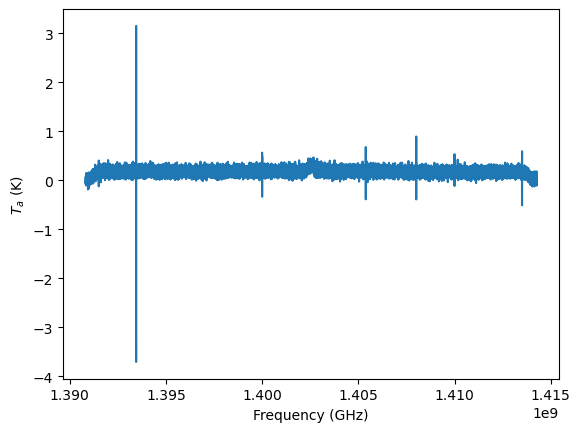

In [23]:
avg = Spectrum(spectral_axis=psscan.calibrated(0).spectral_axis,flux=np.mean(psscan._calibrated)*u.K)
fig,ax=plt.subplots()
ax.plot(avg.spectral_axis,avg.flux)
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(r"$T_a$ (K)")
print(f"T_sys = {np.mean(psscan.tsys)}")

### Try a different polarization and IF and use the OFF scan number
GBTIDL `getps, 153, ifnum=1, plnum=1`

In [31]:
psscan = p.getps(153,plnum=1,ifnum=1)
psscan.calibrate()

PSSCAN nrows = 302


T_sys = 21.32320216292886


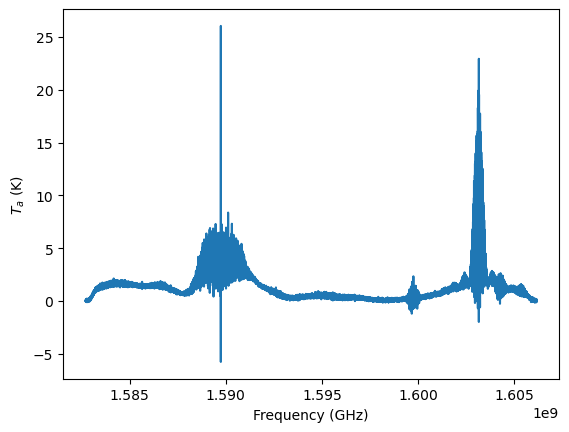

In [32]:
avg = Spectrum(spectral_axis=psscan.calibrated(0).spectral_axis,flux=np.mean(psscan._calibrated)*u.K)
fig,ax=plt.subplots()
ax.plot(avg.spectral_axis,avg.flux)
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(r"$T_a$ (K)")
print(f"T_sys = {np.mean(psscan.tsys)}")

-----
# Debugging from here down.

In [ ]:
df = p._ptable[0]
len(p.select('OBJECT','NGC2415',p._ptable[0]))//p.npol(0)

In [ ]:
psscan.meta

In [ ]:
p.index(0).iloc[psscan._scanrows["OFF"]]["CAL"]

In [ ]:
psscan.calibrate()

In [ ]:
df = p._ptable[0]
scans = [152,153]
df2=df[df["SCAN"].isin([152])]
df3=df[df["SCAN"].isin([153])]
df4=df[df["SCAN"].isin([156])]
un = df2.index.union(df3.index)
un2=df2.index
un3=df3.index
df["SCAN"].iloc[un2]
df3.reindex(un2).index

In [ ]:
on = [152,154,156]
off = [153,155,157]
scans = [152,155]
onrequested = set(on).intersection(scans)
offrequested = set(off).intersection(scans)
sons = list(onrequested.copy())
soffs = list(offrequested.copy())
missingoff = []
missingon = []
setoff = set(off)
seton = set(on)
for i in onrequested:
    expectedoff = i+1
    if len(setoff.intersection([expectedoff])) == 0:
        missingoff.append(expectedoff)
    else:
        soffs.append(expectedoff)
for i in offrequested:
    expectedon = i-1
    if len(seton.intersection([expectedon])) == 0:
        missingon.append(expectedon)
    else:
        sons.append(expectedon)
if len(missingoff) > 0:
    raise ValueError(f"For the requested ON scans {onrequested}, the OFF scans {missingoff} were not present in bintable {bintable}")
if len(missingon) > 0:
    raise ValueError(f"For the requested OFF scans {offrequested}, the ON scans {missingon} were not present in bintable {bintable}")
print("ON",sorted(sons))
print("OFF",sorted(soffs))

In [ ]:
scanlist=p.onoff_scan_list()
print(scanlist)
#scanlist = p.onoff_scan_list([152])
#print(scanlist)
scanlist = p.onoff_scan_list([153])
print(scanlist)
scanlist = p.onoff_scan_list([152,153])
print(scanlist)
scanlist = p.onoff_scan_list(152)
print(scanlist)

In [ ]:
print(sonoff(p.index(0)["SCAN"],p.index(0)["PROCSEQN"]))
myscans = set(sorted([153,155]))
scanlist=p.onoff_scan_list()
print(scanlist)
allscans = set(sorted(scanlist["ON"]+scanlist["OFF"]+[1,2,3,4,5]))
print(allscans)
z=allscans.intersection(myscans)
zz =allscans.difference(myscans)
zzz=myscans.difference(allscans)
print(z,zz,zzz)

In [ ]:
psscan = p.getps(scans=[152])

In [ ]:
df = p._ptable[0]
rows=list(df[df["SCAN"].isin(scans["ON"])].index)
df

In [ ]:
rows=p.onoff_rows()
rows

In [ ]:
show = ["SCAN", "PROCSEQN", "PROCSIZE", "_OBSTYPE"]
df=df[df.columns & show]
df[df["_OBSTYPE"]=="PSWITCHOFF"]

In [ ]:
dict(p._ptable[0].iloc[0])

In [ ]:
df["RESTFREQ"]/=1E9
df["RESTFREQ"]

In [ ]:
show = ["SCAN", "OBJECT", "OBSMODE", "VELOCITY", "PROCSCAN", "PROCSEQN", "PROCTYPE", "PROCSIZE", "RESTFREQ", "IFNUM","FEED", "AZIMUTH", "ELEVATIO", "FDNUM"] 
scan = [60,61]
_df = df[df.columns & show].reindex(columns=show)

In [ ]:
_df["OBSMODE"].str.split(':',expand=True)

In [ ]:

_df[(_df["SCAN"]>=scan[0]) & ( _df["SCAN"] <= scan[1])]

In [ ]:
df["SCAN"]

In [ ]:
df['PROCTYPE']